In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

DIR = '.'
DATA_DIR = f'{DIR}/data'

training_set = torchvision.datasets.MNIST(root=DATA_DIR, train=True, download=True, 
                                          transform=transforms.ToTensor())

training_indices, validation_indices, _, _ = train_test_split(
    range(len(training_set)),
    training_set.targets,
    stratify=training_set.targets,
    test_size=0.1,
)
training_split = torch.utils.data.Subset(training_set, training_indices)
validation_split = torch.utils.data.Subset(training_set, validation_indices)

print(f"{len(training_split)} in training set")
print(f"{len(validation_split)} in validation set")

54000 in training set
6000 in validation set


Epoch: [0][0/8]	Loss 2.7569 (2.7569)	Prec @1 0.1172 (0.1172)	
Epoch 0 | Training accuracy: 0.4169999957084656% | Validation accuracy: 0.5608333349227905%
Epoch: [1][0/8]	Loss 1.5357 (1.5357)	Prec @1 0.5000 (0.5000)	
Epoch 1 | Training accuracy: 0.734000027179718% | Validation accuracy: 0.7903333306312561%
Epoch: [2][0/8]	Loss 0.9671 (0.9671)	Prec @1 0.7969 (0.7969)	
Epoch 2 | Training accuracy: 0.8289999961853027% | Validation accuracy: 0.8703333139419556%


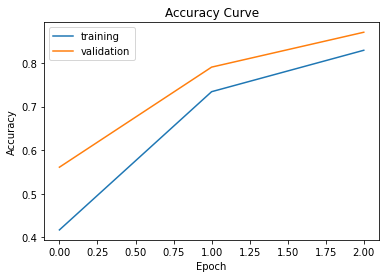

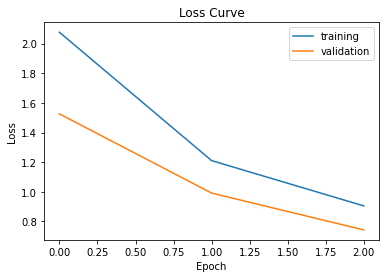

Best Validation Acccuracy: 0.8703


In [16]:
import team36
from team36.mnist.vgg import VGG
from team36.training import train, validate
from team36.defenses.fast_gradient_sign_method_loss import FastGradientSignMethodLoss

learning_rate = 1e-3
momentum = 5e-1
weight_decay = 5e-2
batch_size = 128
epochs = 3

sampler = torch.utils.data.RandomSampler(training_split, replacement=True, num_samples=1000)
training_loader = torch.utils.data.DataLoader(training_split, batch_size=batch_size, sampler=sampler)
test_loader = torch.utils.data.DataLoader(validation_split, batch_size=100, shuffle=False, num_workers=2)

model = VGG()
if torch.cuda.is_available():
    model = model.cuda()

criterion = FastGradientSignMethodLoss(model, nn.CrossEntropyLoss(), alpha=0.5, epsilon=0.25)

optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                            momentum=momentum, weight_decay=weight_decay)

best = 0.0
best_cm = None
best_model = None
train_accuracy_history = []
train_loss_history = []
validation_accuracy_history = []
validation_loss_history = []
for epoch in range(epochs):
    train_acc, train_loss = train(epoch, training_loader, model, optimizer, criterion)
    train_accuracy_history.append(train_acc)
    train_loss_history.append(train_loss)
    
    acc, cm, loss = validate(epoch, test_loader, model, criterion, no_grad=False)
    validation_accuracy_history.append(acc)
    validation_loss_history.append(loss)
    
    print("Epoch {0} | Training accuracy: {1}% | Validation accuracy: {2}%".format(epoch, train_acc, acc))
    
    if acc > best:
        best = acc
        best_cm = cm
        best_model = copy.deepcopy(model)
        
training_curve, = plt.plot(train_accuracy_history, label='training')
validation_curve, = plt.plot(validation_accuracy_history, label='validation')
plt.title('Accuracy Curve')
plt.legend(handles=[training_curve, validation_curve])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

training_curve, = plt.plot(train_loss_history, label='training')
validation_curve, = plt.plot(validation_loss_history, label='validation')
plt.title('Loss Curve')
plt.legend(handles=[training_curve, validation_curve])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print('Best Validation Acccuracy: {:.4f}'.format(best))

In [ ]:
torch.save(best_model.state_dict(), f"{DIR}/checkpoints/mnist-vgg-fgsm-reg-defense.pth")